# Comparison of *revrand*'s algorithms on the SARCOS dataset

In this notebook we test how the GLM in *revrand* performs on the inverse dynamics experiment conducted in Gaussian Processes for Machine Learning, Chapter 8, page 182. In this experiment there are 21 dimensions, and 44,484 training examples. All GP's are using square exponential covariance functions, with a seperate lengthscale for each dimension.

In [80]:
import logging
import numpy as np

from sklearn.preprocessing import StandardScaler

from revrand import GeneralisedLinearModel
from revrand.basis_functions import RandomRBF
from revrand.likelihoods import Gaussian
from revrand.btypes import Parameter, Positive
from revrand.metrics import smse, msll
from revrand.utils.datasets import fetch_gpml_sarcos_data
from revrand.optimize import Adam, AdaDelta

from plotting import fancy_yyplot
import matplotlib.pyplot as pl
%matplotlib inline

# Log output to the terminal attached to this notebook
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)


### Settings

In [81]:
lenscale = 10
regulariser = 100
noise = 100
nbases = 500

batch_size = 50
maxiter = 5000
updater = Adam(alpha=0.015, epsilon=1e-7, beta1=0.9, beta2=0.99)


### Load the data

In [82]:
gpml_sarcos = fetch_gpml_sarcos_data()

X_train = gpml_sarcos.train.data
y_train = gpml_sarcos.train.targets

X_test = gpml_sarcos.test.data
y_test = gpml_sarcos.test.targets

Ntrain, D = X_train.shape

print("Training data shape = {}".format(X_train.shape))
print("Testing data shape = {}".format(X_test.shape))
      

Training data shape = (44484, 21)
Testing data shape = (4449, 21)


### Transform targets
As per GPML p23

In [83]:
ymean = y_train.mean()

y_train -= ymean
y_test -= ymean


### Initialise the algorithms

In [84]:
lenscale_init = Parameter(lenscale * np.ones(D), Positive())
var_init = Parameter(noise**2, Positive())
regulariser_init = Parameter(regulariser, Positive())

base = RandomRBF(nbases=nbases, Xdim=D, lenscale_init=lenscale_init)
llhood = Gaussian(var_init=var_init)

glm = GeneralisedLinearModel(llhood,
                             base,
                             regulariser=regulariser_init, 
                             updater=updater,
                             batch_size=batch_size,
                             maxiter=maxiter
                            )


### Train the algorithms

In [85]:
Xscaler = StandardScaler()
Xscaler.fit(X_train)

glm.fit(Xscaler.transform(X_train), y_train)


GeneralisedLinearModel(basis=<revrand.basis_functions.RandomRBF object at 0x7f645bf31080>,
            batch_size=50, likelihood=None, maxiter=5000, postcomp=10,
            regulariser=41.41759160941879, tol=1e-08,
            updater=<revrand.optimize.sgd.Adam object at 0x7f645ab367f0>)

### Predict and score



revrand GLM SMSE = 0.052862793282157386
revrand GLM MSLL = -1.4681717191709394


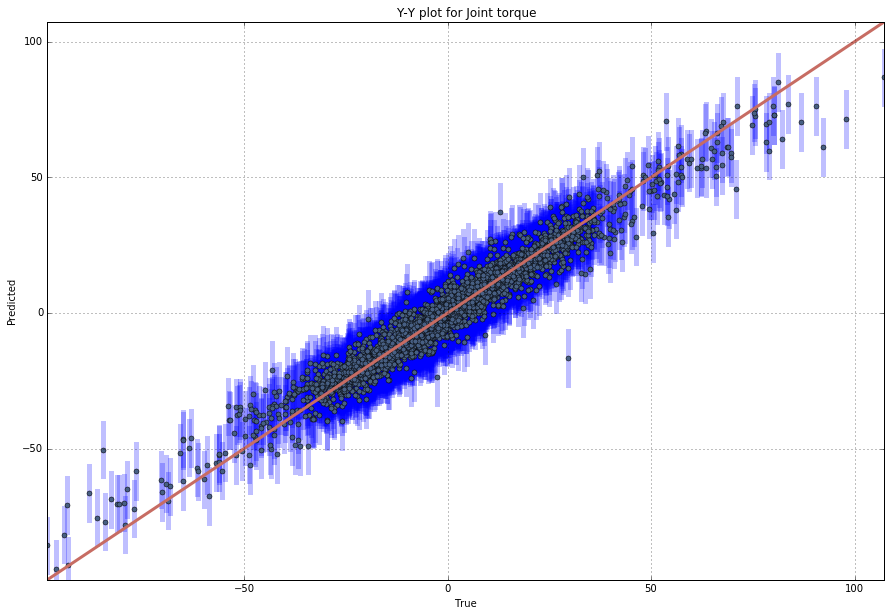

In [86]:
Ey, Vf, _, _ = glm.predict_moments(Xscaler.transform(X_test))
Vy = Vf + glm.like_hypers
Sy = np.sqrt(Vy)

print("revrand GLM SMSE = {}".format(smse(y_test, Ey)))
print("revrand GLM MSLL = {}".format(msll(y_test, Ey, Vy, y_train)))

pl.figure(figsize=(15, 10))
fancy_yyplot(y_test, Ey, Ey - 2 * Sy, Ey + 2 * Sy, "Joint torque")
